## Research Computing for the Earth Sciences 
### Final Project: Correlation between Precipitation and Streamflow (Fall 2020)
#### Ioikuan Ho

## Introduction
Due to climate change, some places are undergoing extreme weather conditions that wet places are getting wetter, whereas dry places are getting drier. In the U.S., some states are facing water shortage, especially the Southwest. Consequently, this project studies whether precipitation would be the main factor causing water shortage problems and learn about the correlation between precipitation and streamflow.

Dataset used: Monthly Total Precipitation ([NOAA CPC](https://psl.noaa.gov/data/gridded/data.unified.html)) and Streamflow ([NOAA National Water Model](https://registry.opendata.aws/nwm-archive/))

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import fsspec
import warnings
import s3fs
from scipy import signal
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12,6)

## Datasets Laoding

#### Precipitation
The data is described in monthly sum. We want to anaylsis the precipiation trend in the lastest 10 years. However, the lastest available date here is 2018-06-01. In this case, we filter the data from 2008 to 2018.

In [22]:
!wget https://zenodo.org/record/3566064/files/precip.V1.0.mon.mean.nc?download=1

--2020-12-12 00:59:20--  https://zenodo.org/record/3566064/files/precip.V1.0.mon.mean.nc?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121934824 (116M) [application/octet-stream]
Saving to: ‘precip.V1.0.mon.mean.nc?download=1’

precip.V1.0.mon.mea 100%[===================>] 116.29M  13.6MB/s    in 8.0s    

2020-12-12 00:59:29 (14.4 MB/s) - ‘precip.V1.0.mon.mean.nc?download=1’ saved [121934824/121934824]



In [23]:
dsp = xr.open_dataset('precip.V1.0.mon.mean.nc?download=1')
dsp = dsp.sel(time=slice('2008', None)).load()

In [24]:
dsp

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 300, time: 126)
Coordinates:
  * lat      (lat) float32 20.125 20.375 20.625 20.875 ... 49.375 49.625 49.875
  * lon      (lon) float32 230.125 230.375 230.625 ... 304.375 304.625 304.875
  * time     (time) datetime64[ns] 2008-01-01 2008-02-01 ... 2018-06-01
Data variables:
    precip   (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    title:          CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    Conventions:    COARDS
    history:        created 05/2012 by CAS from data obtained at NOAA NCEP/CPC
    description:    CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    platform:       Observations
    Comments:       Preciptation is accumulated from 12z of previous day to 1...
    References:     http://www.esrl.noaa.gov/psd/data/gridded/data.unified.da...
    dataset_title:  CPC Unified Gauge-Based Analysis of Daily Precipitation o...

#### Streamflow Dataset 
This dataset is described in every hour mean. The streamflow is a dask array. First, we get the zarr file from aws cloud and open it. Then, we will continue to filter the data after the precipitation is analyzed.

In [5]:
url = 's3://esip-qhub/noaa/nwm'
ds = xr.open_zarr(fsspec.get_mapper(url, requester_pays=True), consolidated=True)
ds

<xarray.Dataset>
Dimensions:         (feature_id: 2729077, time: 227904)
Coordinates:
  * feature_id      (feature_id) int32 101 179 181 ... 1180001803 1180001804
    latitude        (feature_id) float32 dask.array<chunksize=(2729077,), meta=np.ndarray>
    longitude       (feature_id) float32 dask.array<chunksize=(2729077,), meta=np.ndarray>
  * time            (time) datetime64[ns] 1993-01-01 ... 2018-12-31T23:00:00
Data variables:
    elevation       (time, feature_id) float32 dask.array<chunksize=(672, 30000), meta=np.ndarray>
    order           (time, feature_id) int32 dask.array<chunksize=(672, 30000), meta=np.ndarray>
    qBtmVertRunoff  (time, feature_id) float64 dask.array<chunksize=(672, 30000), meta=np.ndarray>
    qBucket         (time, feature_id) float64 dask.array<chunksize=(672, 30000), meta=np.ndarray>
    qSfcLatRunoff   (time, feature_id) float64 dask.array<chunksize=(672, 30000), meta=np.ndarray>
    q_lateral       (time, feature_id) float64 dask.array<chunksize=(672, 30000), meta=np.ndarray>
    streamflow      (time, feature_id) float64 dask.array<chunksize=(672, 30000), meta=np.ndarray>
    velocity        (time, feature_id) float64 dask.array<chunksize=(672, 30000), meta=np.ndarray>
Attributes:
    Conventions:                CF-1.6
    cdm_datatype:               Station
    code_version:               v5.1.0-alpha11
    dev:                        dev_ prefix indicates development/internal me...
    dev_NOAH_TIMESTEP:          3600
    dev_OVRTSWCRT:              1
    dev_channelBucket_only:     0
    dev_channel_only:           0
    featureType:                timeSeries
    model_configuration:        retrospective
    model_initialization_time:  2018-10-01_00:00:00
    model_output_type:          channel_rt
    model_output_valid_time:    2018-12-28_00:00:00
    model_total_valid_times:    2208
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...
    station_dimension:          feature_id
    stream_order_output:        1

## U.S. Precipitation Analysis
First, we want to see which year had the lowest precipitation during the 10 years in the entire United States. Here we have the anomaly 3-month, 6-month, 12-month rolling precipitation mean. The plot shows that the precipitation in 2012 to 2013 is below average. It was decreasing from the second half year of 2009 to second half of 2012 which had the lowest record.

Text(0.5, 1.0, 'U.S. CONUS Rolling 3,6,12-month Average Precipitation Anomaly')

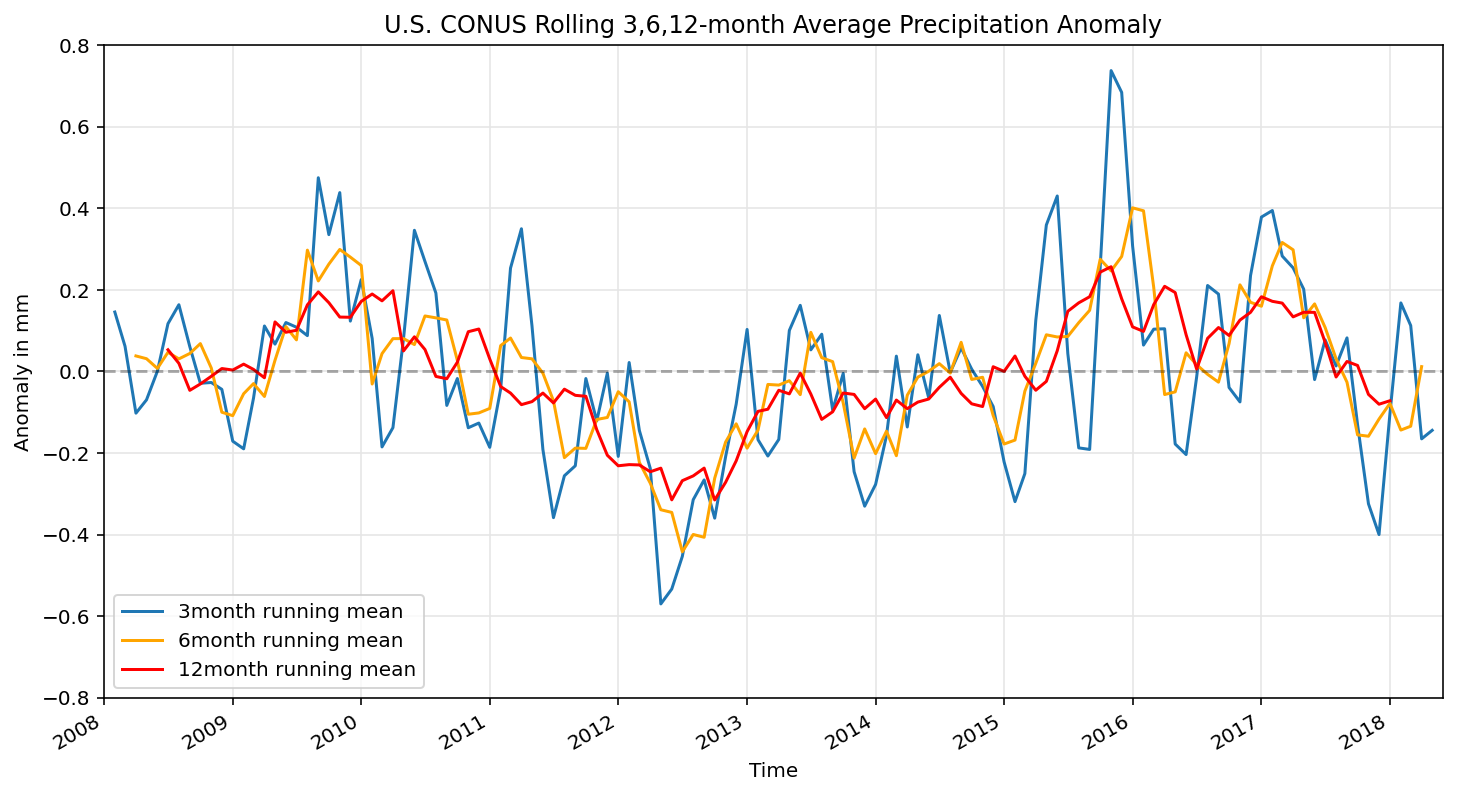

In [6]:
dsp_anom = dsp.groupby('time.month')-dsp.groupby('time.month').mean(dim='time')
rolling_3m= dsp_anom.precip.mean(dim=('lat','lon')).rolling(time=3,center=True).mean()
rolling_6m= dsp_anom.precip.mean(dim=('lat','lon')).rolling(time=6,center=True).mean()
rolling_12m= dsp_anom.precip.mean(dim=('lat','lon')).rolling(time=12,center=True).mean()
rolling_3m.plot(label='3month running mean')
rolling_6m.plot(label='6month running mean',color='orange')
rolling_12m.plot(label='12month running mean',color='red')
plt.xlim(dsp.time[0],dsp.time[-1]);
plt.ylim([-0.8,0.8])
plt.ylabel('Anomaly in mm')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.legend(loc='lower left')
plt.grid(color='0.9')
plt.title('U.S. CONUS Rolling 3,6,12-month Average Precipitation Anomaly')

Since the precipitation decreased from above the mean to below the mean from 2010 to 2012, we should focus on these years. The graphs below show the precipitation distribution over the U.S. in 2010, 2011, and 2012. They indicate that the precipitation in the Southwest area was getting lower and lower. Moreover, it is obvious that part of California, Nevada, Arizona, New Mexico are getting lower and lower precipitation. Therefore, we will pick one from the 4 states to anaylzed the correlation of precipitation and streamflow.

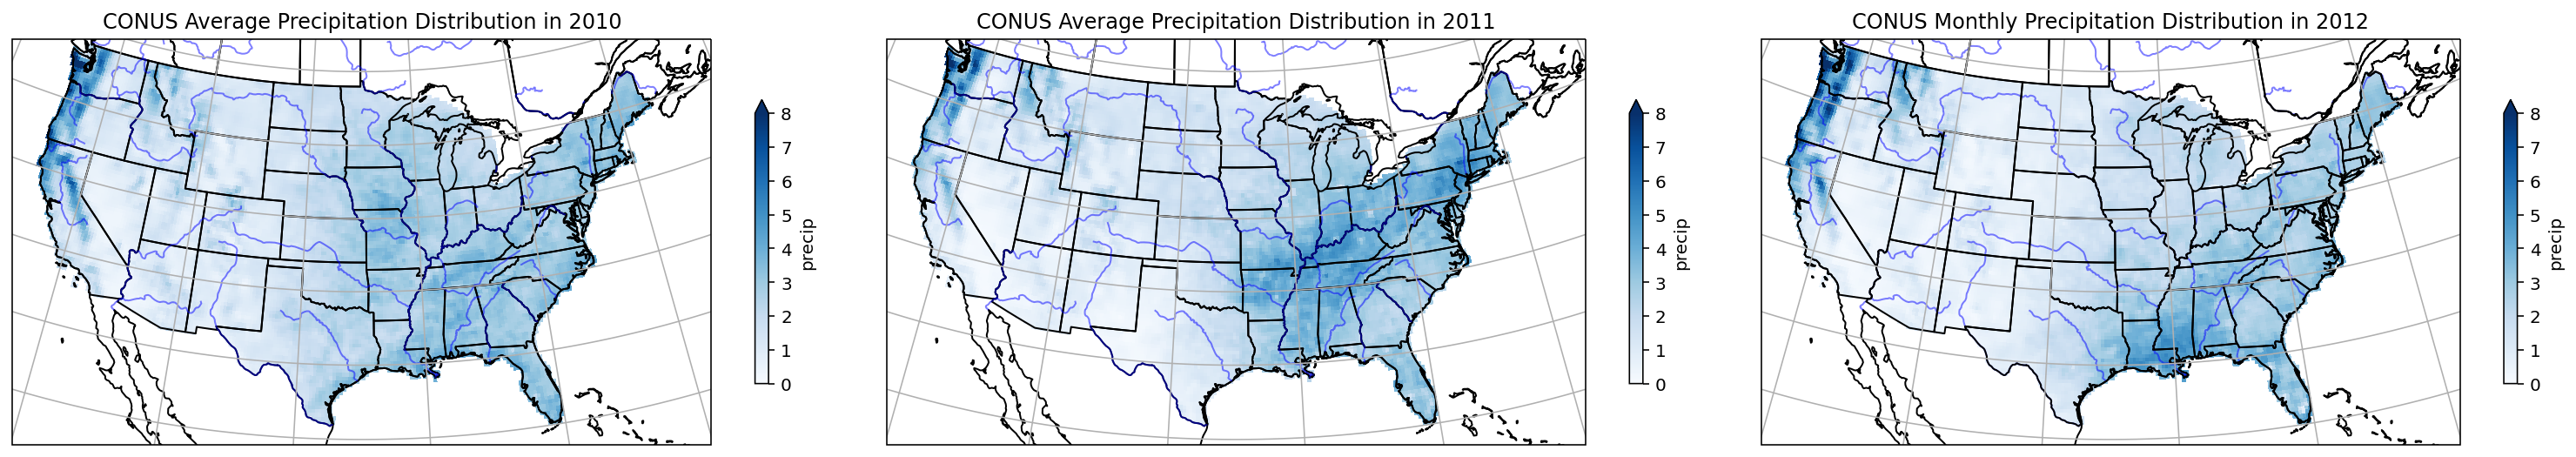

In [7]:
dsp_2012=dsp.sel(time=slice('2012-01-01','2012-12-01')).load()
dsp_2011=dsp.sel(time=slice('2011-01-01','2011-12-01')).load()
dsp_2010=dsp.sel(time=slice('2010-01-01','2010-12-01')).load()

central_lat = 37.5
central_lon = -96
extent = [-120, -70, 22, 50]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')

fig = plt.figure(figsize = (27,10))
ax0 = fig.add_subplot(131,projection=ccrs.LambertConformal(central_lon, central_lat))
ax0.set_extent(extent)
ax0.coastlines()
ax0.gridlines()
ax0.add_feature(cartopy.feature.STATES, edgecolor='black')
dsp_2010.precip.mean(dim='time').plot(ax=ax0,  transform = ccrs.PlateCarree(),cmap='Blues',cbar_kwargs={'shrink': 0.3},vmin=0,vmax=8)
ax0.set_title('CONUS Average Precipitation Distribution in 2010');
ax0.add_feature(rivers_50m, facecolor='None', edgecolor='b',alpha=0.5)

ax1 = fig.add_subplot(132,projection=ccrs.LambertConformal(central_lon, central_lat))
dsp_2011.precip.mean(dim='time').plot(ax=ax1,  transform = ccrs.PlateCarree(),cmap='Blues',cbar_kwargs={'shrink': 0.3},vmin=0,vmax=8)
ax1.set_title('CONUS Average Precipitation Distribution in 2011');
ax1.set_extent(extent)
ax1.coastlines()
ax1.gridlines()
ax1.add_feature(cartopy.feature.STATES, edgecolor='black')
ax1.add_feature(rivers_50m, facecolor='None', edgecolor='b',alpha=0.5)

ax2 = fig.add_subplot(133,projection=ccrs.LambertConformal(central_lon, central_lat))
ax2.set_extent(extent)
ax2.coastlines()
ax2.gridlines()
ax2.add_feature(rivers_50m, facecolor='None', edgecolor='b',alpha=0.5)
ax2.add_feature(cartopy.feature.STATES, edgecolor='black')
dsp_2012.precip.mean(dim='time').plot(ax=ax2,  transform = ccrs.PlateCarree(),cmap='Blues',cbar_kwargs={'shrink': 0.3},vmin=0,vmax=8)
ax2.set_title('CONUS Monthly Precipitation Distribution in 2012');

fig.subplots_adjust(wspace=0.001, hspace=0)

Here, we picked Arizona to analyze its montly precipitation. The belowed plot tells us that most of the time during the period from 2011 to 2013 are below average. In this case, would the streamflow be depend on the precipitation?

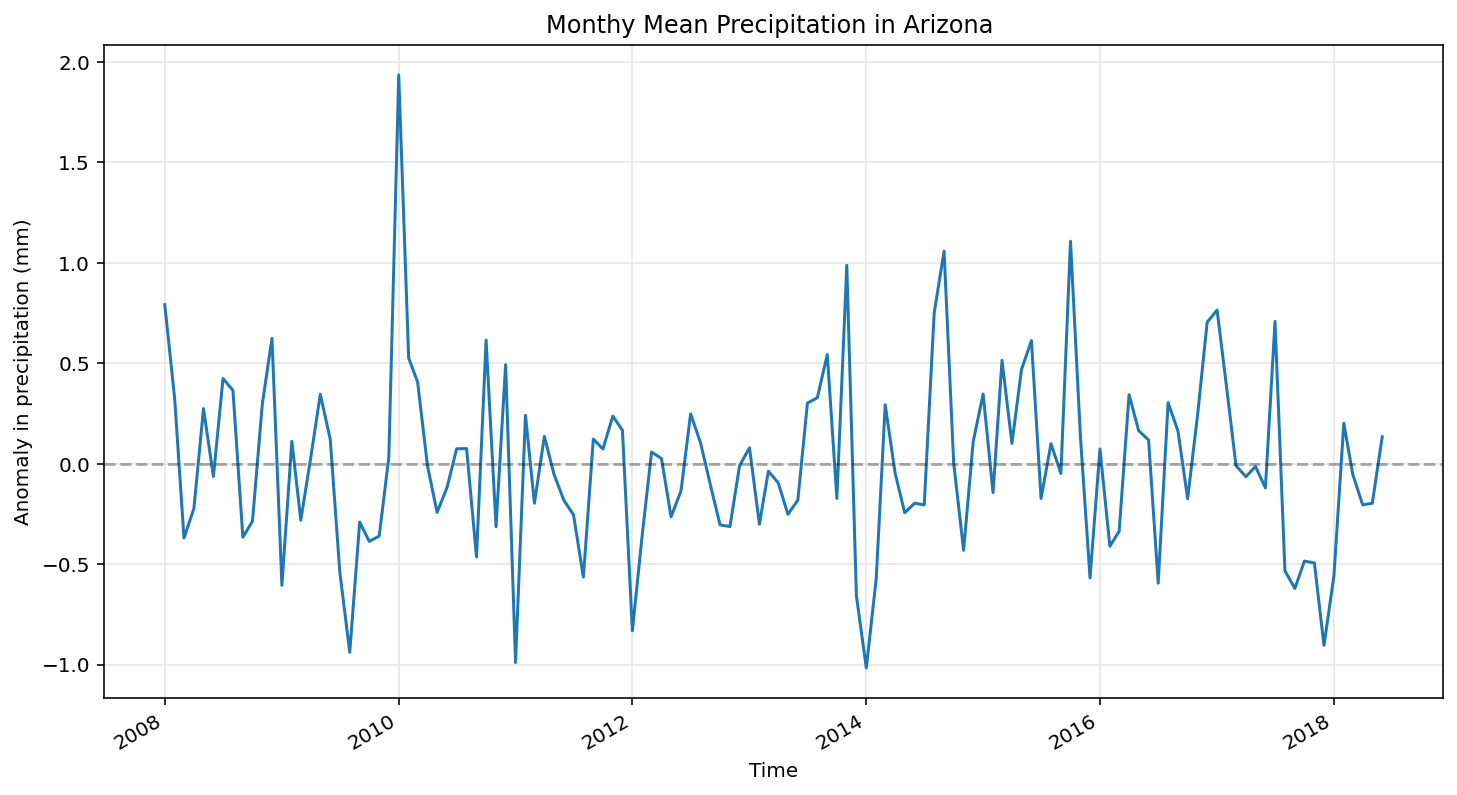

In [8]:
az=dsp.sel(lat=slice(31.36,37),lon=slice(245.45,251)).load()
az_anom = az.groupby('time.month')-az.groupby('time.month').mean(dim='time')
monthly=az_anom.precip.mean(dim=('lat','lon')).plot()
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.title('Monthy Mean Precipitation in Arizona ')
plt.ylabel('Anomaly in precipitation (mm)');
plt.grid(color='0.9')

## Streamflow Analysis
First, we need to find the streamflow stations in Arizona. 
A function was set up to find the station IDs closest to the selected longitude and latitude. 

In [9]:
# find the indices of the points in (x,y) closest to the points in (xi,yi)
def nearxy(x,y,xi,yi):
    ind = np.ones(len(xi),dtype=int)
    for i in range(len(xi)):
        dist = np.sqrt((x-xi[i])**2+(y-yi[i])**2)
        ind[i] = dist.argmin()
    return ind

Then, the longitude and latitude are sliced into 50 sections on each vector to find the Real IDs in each small sections. It gives 2500 stations in total.

In [10]:
lat= np.ones([50,1])*np.linspace(31,37, 50)
lat=lat.transpose()
lon= np.linspace(251-360,245-360, 50)
arr=np.array([],dtype=np.int64)
for m in range(len(lon)):
    ind= nearxy(ds.longitude,ds.latitude,lon, lat[m])
    arr=np.concatenate((arr,ind))
arr

array([2702568, 2659103, 2659100, ..., 2149490, 2150106, 2150297])

Since some of the stations recording area is larger, there are some IDs repeated. Therefore, the duplicated IDs should be taken out. It ends up have 2285 stations. 

In [11]:
arr=np.unique(arr)
np.count_nonzero(arr)

2285

According to the Real IDs, we can find the streamflows' locations and data, and we can filter the years from 2008 to 2018. 

In [12]:
dsf = ds.streamflow[:,arr].sel(time=slice('2008','2018')).load()

After the streamflow dataset came out, we can find the Feature IDs (which is different than Real IDs) which will be mainly focused to anaylze streamflow activity in a specific location, and use the location to find the corresponding precipitation in that location.

In [13]:
id=np.array(dsf.feature_id)
np.count_nonzero(id)

2285

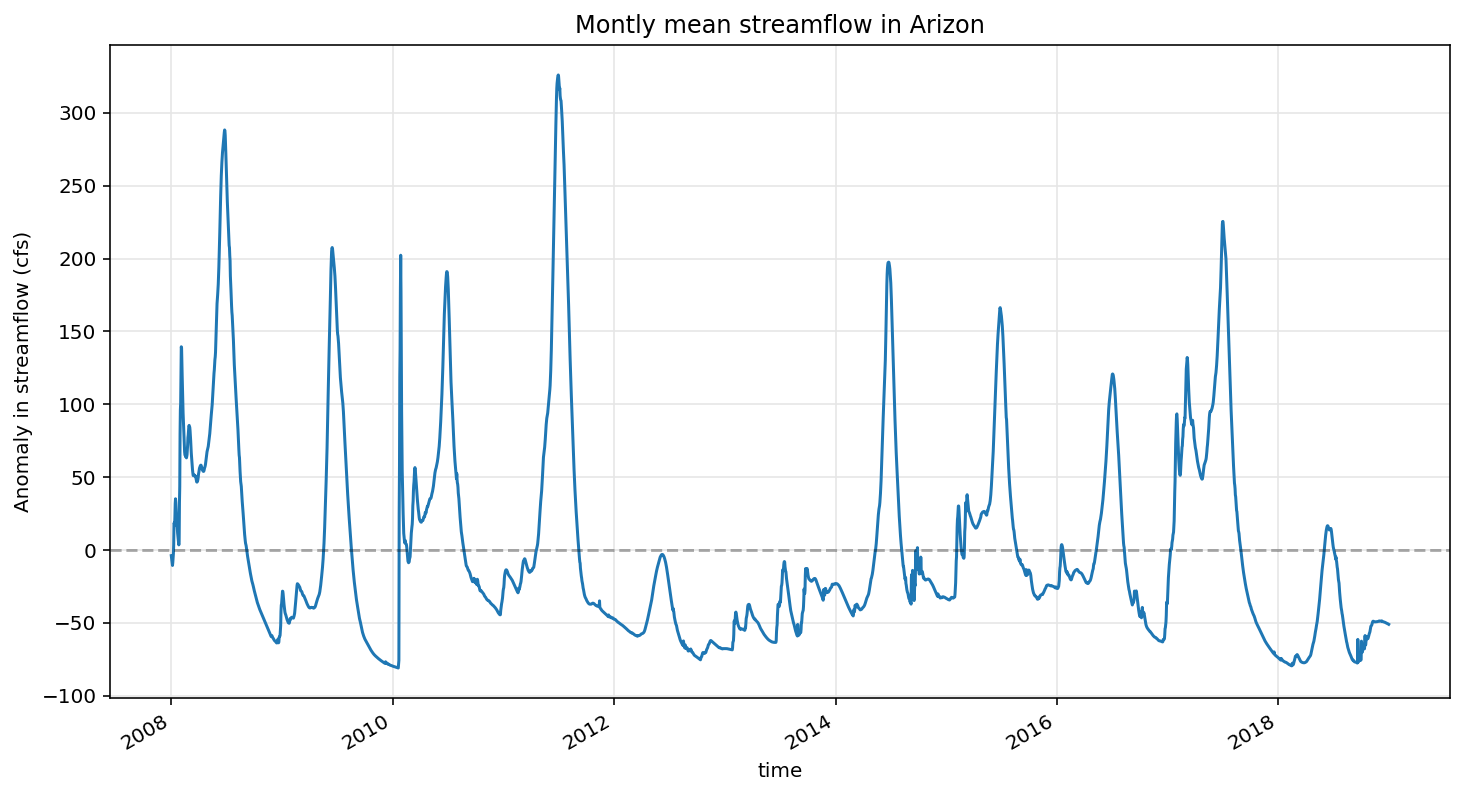

In [14]:
dsf = dsf.resample(time='D').sum(dim='time')
dsf_anom= dsf-dsf.mean(dim='time')
dsf_anom.mean(dim='feature_id').plot()
plt.title('Montly mean streamflow in Arizon')
plt.ylabel('Anomaly in streamflow (cfs)')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.grid(color='0.9');

From the graph showed above, we can see that the mean streamflow is also below average started from the end of 2011 to the beginning of 2014. In comparing with the precipitation, we can see that they are some how related, but the occurrance of below-average streamflow seems to be slightly delayed. Therefore, correlation should be used to anaylze their relationship precisely in the following part.

## Correlation
Cross correlation is used to analyze the similarity between precipitation and streamflow. 

#### Standardizing data:

In order to learn the dependency between two different datasets, we need to standardize the data. 
Here we have the precipitation data in Arizona and filter to 2010, 2011, 2012, and 2013.

In [15]:
# Precipitation in Arizona
az10=dsp.sel(lat=slice(31,37),lon=slice(245,251),time=slice('2010-01-01','2010-12-31')).load()
az10_n = (az10-az10.mean(dim='time'))/az10.std()

az11=dsp.sel(lat=slice(31,37),lon=slice(245,251),time=slice('2011-01-01','2011-12-31')).load()
az11_n = (az11-az11.mean(dim='time'))/az11.std()

az12=dsp.sel(lat=slice(31,37),lon=slice(245,251),time=slice('2012-01-01','2012-12-31')).load()
az12_n = (az12-az12.mean(dim='time'))/az12.std()

az13=dsp.sel(lat=slice(31,37),lon=slice(245,251),time=slice('2013-01-01','2013-12-31')).load()
az13_n = (az13-az13.mean(dim='time'))/az13.std()

Next, we standardized the streamflow data and resample it by month. Since precipitation dataset is described in month, the streamflow data has to be resample to the same size of precipitation in order to compare with it. We focus on the streamflow data in the same time periods.

In [16]:
# Streamflow in Arizona
dsf_10=ds.streamflow[:,arr].sel(time=slice('2010-01-01','2010-12-31')).load()
dsf_11=ds.streamflow[:,arr].sel(time=slice('2011-01-01','2011-12-31')).load()
dsf_12=ds.streamflow[:,arr].sel(time=slice('2012-01-01','2012-12-31')).load()
dsf_13=ds.streamflow[:,arr].sel(time=slice('2013-01-01','2013-12-31')).load()

In [17]:
dsf_D_10=dsf_10.resample(time='D').sum(dim='time')
dsf_n_10= (dsf_D_10-dsf_D_10.mean(dim='time'))/dsf_D_10.std()
dsf_M_10=dsf_n_10.resample(time='M').sum(dim='time')
dsf_M_10

dsf_D_11=dsf_11.resample(time='D').sum(dim='time')
dsf_n_11= (dsf_D_11-dsf_D_11.mean(dim='time'))/dsf_D_11.std()
dsf_M_11=dsf_n_11.resample(time='M').sum(dim='time')
dsf_M_11

dsf_D_12=dsf_12.resample(time='D').sum(dim='time')
dsf_n_12= (dsf_D_12-dsf_D_12.mean(dim='time'))/dsf_D_12.std()
dsf_M_12=dsf_n_12.resample(time='M').sum(dim='time')

dsf_D_13=dsf_13.resample(time='D').sum(dim='time')
dsf_n_13= (dsf_D_13-dsf_D_13.mean(dim='time'))/dsf_D_13.std()
dsf_M_13=dsf_n_13.resample(time='M').sum(dim='time')

Extracting the longitude and latitude of each 2285 stations.

In [18]:
lon_p=np.array(dsf_n_10.longitude)+360
lat_p=np.array(dsf_n_10.latitude)

#### Cross-Correlation calculation:

Here is the big picture of how the two datasets relate to each other in the entire Arizona in year of 2010, 2011, 2012, 2013. The cross-correlation coefficent are calculated based on Arizona's monthly mean of precipitation and monthly mean of streamflow. 

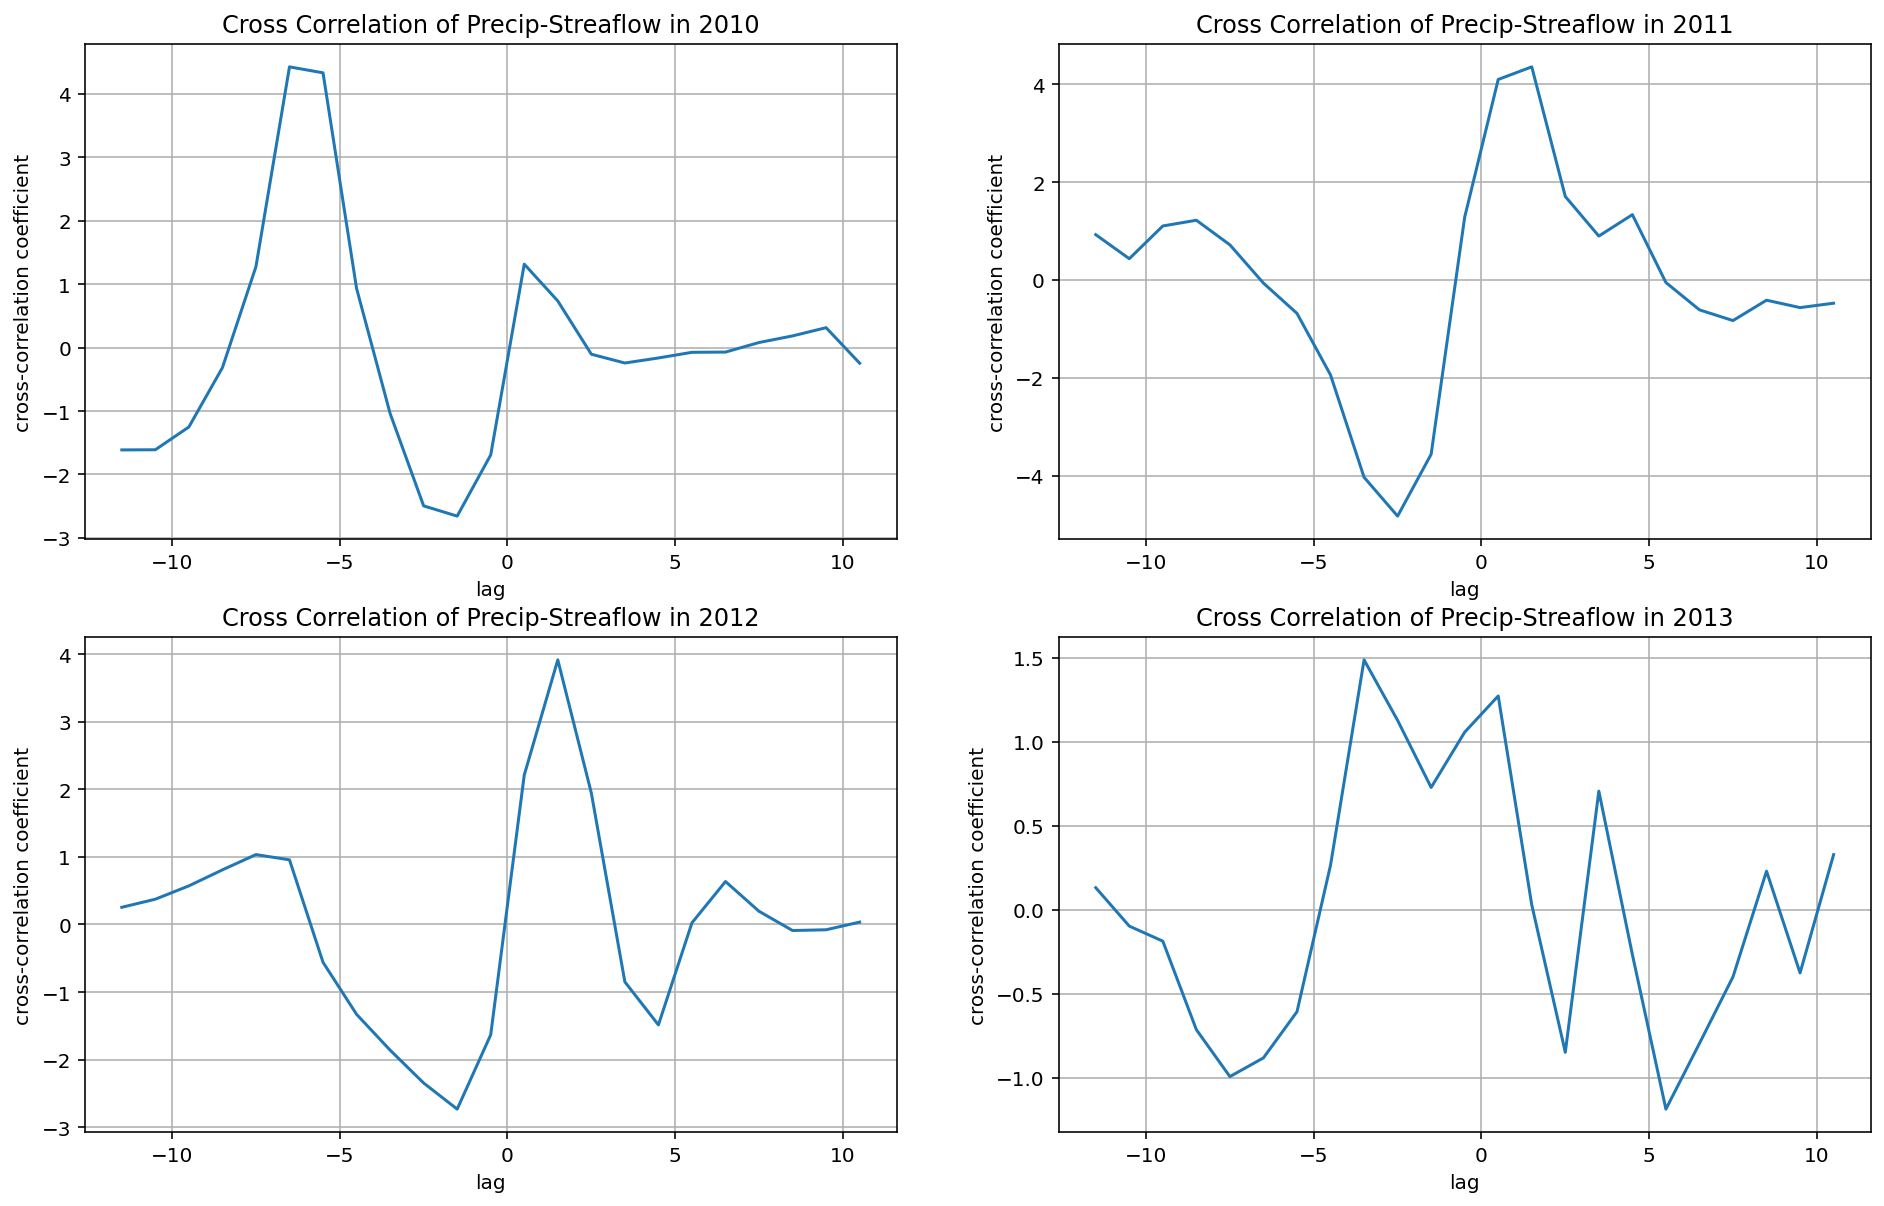

In [19]:
y10=signal.correlate(az10_n.precip.mean(dim=('lon','lat')),dsf_M_10.mean(dim='feature_id'),method='auto')
y11=signal.correlate(az11_n.precip.mean(dim=('lon','lat')),dsf_M_11.mean(dim='feature_id'),method='auto')
y12=signal.correlate(az12_n.precip.mean(dim=('lon','lat')),dsf_M_12.mean(dim='feature_id'),method='auto')
y13=signal.correlate(az13_n.precip.mean(dim=('lon','lat')),dsf_M_13.mean(dim='feature_id'),method='auto')

x=np.arange(-len(y10)/2,len(y10)/2,1)
fig, ((c10, c11), (c12,c13)) = plt.subplots(2, 2, figsize=(16,10))
c10.plot(x,y10)
c10.set_title('Cross Correlation of Precip-Streaflow in 2010')
c10.set_xlabel('lag')
c10.set_ylabel('cross-correlation coefficient')
c10.grid()
c11.plot(x,y11)
c11.set_title('Cross Correlation of Precip-Streaflow in 2011')
c11.set_xlabel('lag')
c11.set_ylabel('cross-correlation coefficient')
c11.grid()
c12.plot(x,y12)
c12.set_title('Cross Correlation of Precip-Streaflow in 2012')
c12.set_xlabel('lag')
c12.set_ylabel('cross-correlation coefficient')
c12.grid()
c13.plot(x,y13)
c13.set_title('Cross Correlation of Precip-Streaflow in 2013')
c13.set_xlabel('lag')
c13.set_ylabel('cross-correlation coefficient')
c13.grid()
fig.show()

The graphs above tell us that the maximum correlation coefficiets happen when the lags are close to 0 except the year of 2010. This shows that there is a dependency between two of them.

We know that there are many factors controlling the streamflow of a river. Therefore, the cross correlation coefficient between precipitation and streamflow should be calculated by each locations and each years. Then, the maximum coefficient of each location is extracted and placed into a dataframe which gives 2285 cross-correlation coefficient for each year.

In [20]:
corr_m_10 = np.zeros_like(dsf_n_10.feature_id)
corr_m_11 = np.zeros_like(dsf_n_11.feature_id)
corr_m_12 = np.zeros_like(dsf_n_12.feature_id)
corr_m_13 = np.zeros_like(dsf_n_13.feature_id)

for i in range(len(id)):
    corr_10 = signal.correlate(az10_n.precip.sel(lon=lon_p[i],lat=lat_p[i], method='nearest'),dsf_M_10.sel(feature_id=id[i]),method='auto')
    corr_10 = corr_10.astype('Int32')     
    corr_m_10[i]=corr_10.max()

for i in range(len(id)):
    corr_11=signal.correlate(az11_n.precip.sel(lon=lon_p[i],lat=lat_p[i], method='nearest'),dsf_M_11.sel(feature_id=id[i]),method='auto')
    corr_11= corr_11.astype('Int32')     
    corr_m_11[i]=corr_11.max()

for i in range(len(id)):
    corr_12=signal.correlate(az12_n.precip.sel(lon=lon_p[i],lat=lat_p[i], method='nearest'),dsf_M_12.sel(feature_id=id[i]),method='auto')
    corr_12= corr_12.astype('Int32')     
    corr_m_12[i]=corr_12.max()

for i in range(len(id)):
    corr_13=signal.correlate(az13_n.precip.sel(lon=lon_p[i],lat=lat_p[i], method='nearest'),dsf_M_13.sel(feature_id=id[i]),method='auto')
    corr_13= corr_13.astype('Int32')     
    corr_m_13[i]=corr_13.max()

In [21]:
df = pd.DataFrame(data=id, columns= ['feature_id'])
df['lon']=pd.DataFrame(data=lon_p)
df['lat']=pd.DataFrame(data=lat_p)
df['corr_max_10'] =pd.DataFrame(data=corr_m_10)
df['corr_max_11'] =pd.DataFrame(data=corr_m_11)
df['corr_max_12'] =pd.DataFrame(data=corr_m_12)
df['corr_max_13'] =pd.DataFrame(data=corr_m_13)

df

,feature_id,lon,lat,corr_max_10,corr_max_11,corr_max_12,corr_max_13
0,1384152,249.286194,37.010605,0,0,0,0
1,1384164,249.758850,37.005230,0,0,0,0
2,1385206,250.031937,37.015705,0,0,0,0
3,1385784,249.412811,36.995853,0,0,0,0
4,1385798,249.178055,36.990009,0,0,0,0
...,...,...,...,...,...,...,...
2280,1180001287,245.013885,32.587898,-2147483648,-2147483648,-2147483648,-2147483648
2281,1180001578,244.992493,32.503860,-2147483648,-2147483648,-2147483648,-2147483648
2282,1180001588,244.974762,32.499859,-2147483648,-2147483648,-2147483648,-2147483648
2283,1180001722,244.608780,32.371819,-2147483648,-2147483648,-2147483648,-2147483648


In [22]:
# mask out the Nan value locations which the values are shown as -2147483648 in this case.
df_mask=df[(df.corr_max_10 != -2147483648) & (df.corr_max_11 != -2147483648) & (df.corr_max_12 != -2147483648) & (df.corr_max_13 != -2147483648)]

Plot the coefficients of each locations in map:

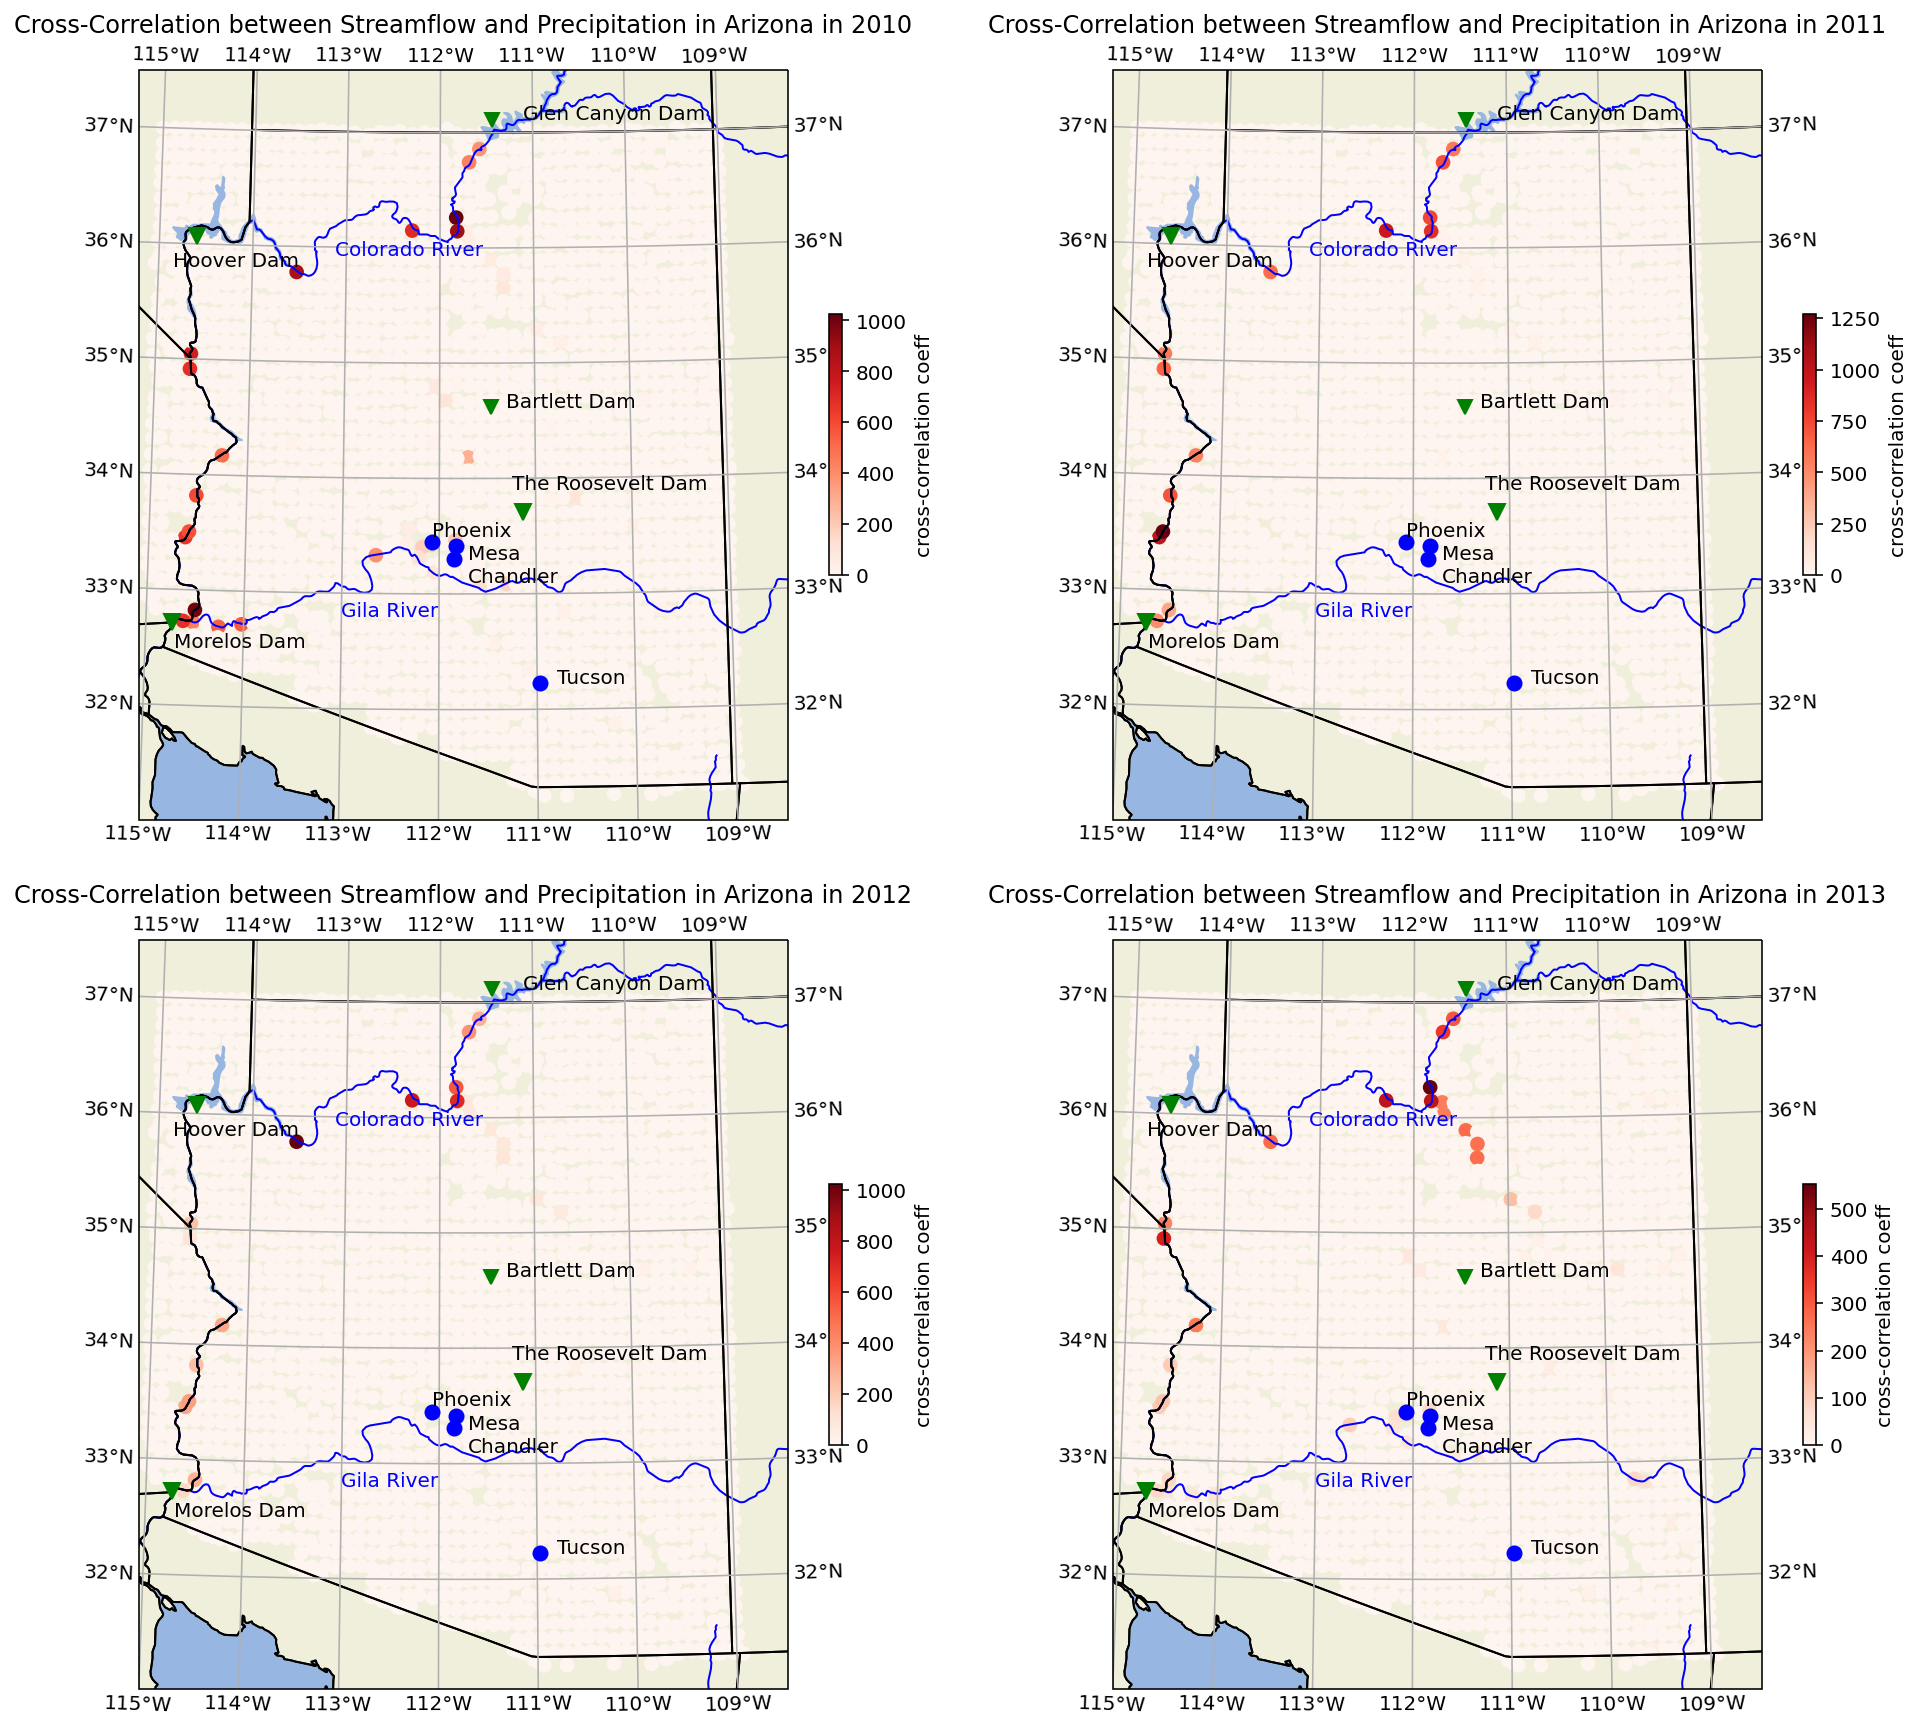

In [23]:
central_lat = 34.0489
central_lon = -111.0937
extent = [-108.5+360, -115+360, 31, 37.5]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m')

fig = plt.figure(figsize = (16,16))
ax0 = fig.add_subplot(221,projection=ccrs.LambertConformal(central_lon, central_lat))
ax0.set_extent(extent)
ax0.coastlines()
ax0.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax0.add_feature(cartopy.feature.OCEAN)
ax0.add_feature(cartopy.feature.LAND)
ax0.add_feature(cartopy.feature.LAKES)
ax0.add_feature(rivers_50m, facecolor='None', edgecolor='b')
ax0.add_feature(cartopy.feature.STATES, edgecolor='black')
df_plot0=plt.scatter(df_mask.lon, df_mask.lat,c=df_mask.corr_max_10,marker='o',s=40,cmap='Reds',transform = ccrs.PlateCarree())
fig.colorbar(df_plot0,label='cross-correlation coeff',shrink=0.3)
plt.title('Cross-Correlation between Streamflow and Precipitation in Arizona in 2010',fontsize=12);
ax0.plot(-112.0740, 33.4484,  'bo', markersize=7, transform=ccrs.Geodetic())
ax0.text(-112.0740, 33.5, 'Phoenix', transform=ccrs.Geodetic()), 
ax0.plot(-111.82776885415164, 33.416846662942426,  'bo', markersize=7, transform=ccrs.Geodetic())
ax0.text(-111.7, 33.3, 'Mesa', transform=ccrs.Geodetic())
ax0.plot(-111.84848616158811, 33.30551142848365,  'bo', markersize=7, transform=ccrs.Geodetic())
ax0.text(-111.7, 33.1, 'Chandler', transform=ccrs.Geodetic())
ax0.plot(-110.9747, 32.2226 ,  'bo', markersize=7, transform=ccrs.Geodetic())
ax0.text(-110.8, 32.2226, 'Tucson', transform=ccrs.Geodetic())
ax0.plot(-111.46393611472229 , 34.617421909671165, 'gv', markersize=7, transform=ccrs.Geodetic())
ax0.text(-111.3 , 34.617421909671165, 'Bartlett Dam', transform=ccrs.Geodetic()) 
ax0.plot( -111.43642143179946, 37.1146680137846,'gv', markersize=7, transform=ccrs.Geodetic())
ax0.text(-111.1, 37.1146680137846, 'Glen Canyon Dam', transform=ccrs.Geodetic())
ax0.plot( -114.731782940717,32.71896714774348, 'gv', markersize=8, transform=ccrs.Geodetic())
ax0.text(-114.7,32.5, 'Morelos Dam', transform=ccrs.Geodetic())
ax0.plot(-114.5997777906256, 36.070307409765, 'gv', markersize=8, transform=ccrs.Geodetic())
ax0.text(-114.85,35.8, 'Hoover Dam', transform=ccrs.Geodetic())
ax0.plot(-111.13683031629554, 33.7061665644044,  'gv', markersize=8, transform=ccrs.Geodetic())
ax0.text(-111.25,33.9, 'The Roosevelt Dam', transform=ccrs.Geodetic())
ax0.text(-113, 32.8, 'Gila River', color='b',transform=ccrs.Geodetic())
ax0.text( -113.1189, 35.9237, 'Colorado River', color='b', transform=ccrs.Geodetic())

ax1 = fig.add_subplot(222,projection=ccrs.LambertConformal(central_lon, central_lat))
ax1.set_extent(extent)
ax1.coastlines()
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax1.add_feature(cartopy.feature.OCEAN)
ax1.add_feature(cartopy.feature.LAND)
ax1.add_feature(cartopy.feature.LAKES)
ax1.add_feature(rivers_50m, facecolor='None', edgecolor='b')
ax1.add_feature(cartopy.feature.STATES, edgecolor='black')
df_plot1=plt.scatter(df_mask.lon, df_mask.lat,c=df_mask.corr_max_11,marker='o',s=40,cmap='Reds',transform = ccrs.PlateCarree())
fig.colorbar(df_plot1,label='cross-correlation coeff',shrink=0.3)
plt.title('Cross-Correlation between Streamflow and Precipitation in Arizona in 2011',fontsize=12);
ax1.plot(-111.82776885415164, 33.416846662942426,  'bo', markersize=7, transform=ccrs.Geodetic())
ax1.text(-111.7, 33.3, 'Mesa', transform=ccrs.Geodetic())
ax1.plot(-112.0740, 33.4484,  'bo', markersize=7, transform=ccrs.Geodetic())
ax1.text(-112.0740, 33.5, 'Phoenix', transform=ccrs.Geodetic())
ax1.plot(-111.84848616158811, 33.30551142848365,  'bo', markersize=7, transform=ccrs.Geodetic())
ax1.text(-111.7, 33.1, 'Chandler', transform=ccrs.Geodetic())
ax1.plot(-110.9747, 32.2226 ,  'bo', markersize=7, transform=ccrs.Geodetic())
ax1.text(-110.8, 32.2226, 'Tucson', transform=ccrs.Geodetic())
ax1.plot(-111.46393611472229 , 34.617421909671165, 'gv', markersize=7, transform=ccrs.Geodetic())
ax1.text(-111.3 , 34.617421909671165, 'Bartlett Dam', transform=ccrs.Geodetic()) 
ax1.plot( -111.43642143179946, 37.1146680137846,'gv', markersize=7, transform=ccrs.Geodetic())
ax1.text(-111.1, 37.1146680137846, 'Glen Canyon Dam', transform=ccrs.Geodetic())
ax1.plot( -114.731782940717,32.71896714774348, 'gv', markersize=8, transform=ccrs.Geodetic())
ax1.text(-114.7,32.5, 'Morelos Dam', transform=ccrs.Geodetic())
ax1.plot(-114.5997777906256, 36.070307409765, 'gv', markersize=8, transform=ccrs.Geodetic())
ax1.text(-114.85,35.8, 'Hoover Dam', transform=ccrs.Geodetic())
ax1.plot(-111.13683031629554, 33.7061665644044,  'gv', markersize=8, transform=ccrs.Geodetic())
ax1.text(-111.25,33.9, 'The Roosevelt Dam', transform=ccrs.Geodetic())
ax1.text(-113, 32.8, 'Gila River', color='b',transform=ccrs.Geodetic())
ax1.text( -113.1189, 35.9237, 'Colorado River', color='b', transform=ccrs.Geodetic())

ax2 = fig.add_subplot(223,projection=ccrs.LambertConformal(central_lon, central_lat))
ax2.set_extent(extent)
ax2.coastlines()
ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax2.add_feature(cartopy.feature.OCEAN)
ax2.add_feature(cartopy.feature.LAND)
ax2.add_feature(cartopy.feature.LAKES)
ax2.add_feature(rivers_50m, facecolor='None', edgecolor='b')
ax2.add_feature(cartopy.feature.STATES, edgecolor='black')
df_plot2=plt.scatter(df_mask.lon, df_mask.lat,c=df_mask.corr_max_12,marker='o',s=40,cmap='Reds',transform = ccrs.PlateCarree())
fig.colorbar(df_plot0,label='cross-correlation coeff',shrink=0.3)
plt.title('Cross-Correlation between Streamflow and Precipitation in Arizona in 2012',fontsize=12);
ax2.plot(-111.82776885415164, 33.416846662942426,  'bo', markersize=7, transform=ccrs.Geodetic())
ax2.text(-111.7, 33.3, 'Mesa', transform=ccrs.Geodetic())
ax2.plot(-112.0740, 33.4484,  'bo', markersize=7, transform=ccrs.Geodetic())
ax2.text(-112.0740, 33.5, 'Phoenix', transform=ccrs.Geodetic())
ax2.plot(-110.9747, 32.2226 ,  'bo', markersize=7, transform=ccrs.Geodetic())
ax2.text(-110.8, 32.2226, 'Tucson', transform=ccrs.Geodetic())
ax2.plot(-111.84848616158811, 33.30551142848365,  'bo', markersize=7, transform=ccrs.Geodetic())
ax2.text(-111.7, 33.1, 'Chandler', transform=ccrs.Geodetic())
ax2.plot(-111.46393611472229 , 34.617421909671165, 'gv', markersize=7, transform=ccrs.Geodetic())
ax2.text(-111.3 , 34.617421909671165, 'Bartlett Dam', transform=ccrs.Geodetic()) 
ax2.plot( -111.43642143179946, 37.1146680137846,'gv', markersize=7, transform=ccrs.Geodetic())
ax2.text(-111.1, 37.1146680137846, 'Glen Canyon Dam', transform=ccrs.Geodetic())
ax2.plot( -114.731782940717,32.71896714774348, 'gv', markersize=8, transform=ccrs.Geodetic())
ax2.text(-114.7,32.5, 'Morelos Dam', transform=ccrs.Geodetic())
ax2.plot(-114.5997777906256, 36.070307409765, 'gv', markersize=8, transform=ccrs.Geodetic())
ax2.text(-114.85,35.8, 'Hoover Dam', transform=ccrs.Geodetic())
ax2.plot(-111.13683031629554, 33.7061665644044,  'gv', markersize=8, transform=ccrs.Geodetic())
ax2.text(-111.25,33.9, 'The Roosevelt Dam', transform=ccrs.Geodetic())
ax2.text(-113, 32.8, 'Gila River', color='b',transform=ccrs.Geodetic())
ax2.text( -113.1189, 35.9237, 'Colorado River', color='b', transform=ccrs.Geodetic())

ax3 = fig.add_subplot(224,projection=ccrs.LambertConformal(central_lon, central_lat))
ax3.set_extent(extent)
ax3.coastlines()
ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax3.add_feature(cartopy.feature.OCEAN)
ax3.add_feature(cartopy.feature.LAND)
ax3.add_feature(cartopy.feature.LAKES)
ax3.add_feature(rivers_50m, facecolor='None', edgecolor='b')
ax3.add_feature(cartopy.feature.STATES, edgecolor='black')
df_plot3=plt.scatter(df_mask.lon, df_mask.lat,c=df_mask.corr_max_13,marker='o',s=40,cmap='Reds',transform = ccrs.PlateCarree())
fig.colorbar(df_plot3,label='cross-correlation coeff',shrink=0.3)
plt.title('Cross-Correlation between Streamflow and Precipitation in Arizona in 2013',fontsize=12);
ax3.plot(-111.82776885415164, 33.416846662942426,  'bo', markersize=7, transform=ccrs.Geodetic())
ax3.text(-111.7, 33.3, 'Mesa', transform=ccrs.Geodetic())
ax3.plot(-111.84848616158811, 33.30551142848365,  'bo', markersize=7, transform=ccrs.Geodetic())
ax3.text(-111.7, 33.1, 'Chandler', transform=ccrs.Geodetic())
ax3.plot(-112.0740, 33.4484,  'bo', markersize=7, transform=ccrs.Geodetic())
ax3.text(-112.0740, 33.5, 'Phoenix', transform=ccrs.Geodetic())
ax3.plot(-110.9747, 32.2226 ,  'bo', markersize=7, transform=ccrs.Geodetic())
ax3.text(-110.8, 32.2226, 'Tucson', transform=ccrs.Geodetic())
ax3.plot(-111.46393611472229 , 34.617421909671165, 'gv', markersize=7, transform=ccrs.Geodetic())
ax3.text(-111.3 , 34.617421909671165, 'Bartlett Dam', transform=ccrs.Geodetic()) 
ax3.plot( -111.43642143179946, 37.1146680137846,'gv', markersize=7, transform=ccrs.Geodetic())
ax3.text(-111.1, 37.1146680137846, 'Glen Canyon Dam', transform=ccrs.Geodetic())
ax3.plot( -114.731782940717,32.71896714774348, 'gv', markersize=8, transform=ccrs.Geodetic())
ax3.text(-114.7,32.5, 'Morelos Dam', transform=ccrs.Geodetic())
ax3.plot(-114.5997777906256, 36.070307409765, 'gv', markersize=8, transform=ccrs.Geodetic())
ax3.text(-114.85,35.8, 'Hoover Dam', transform=ccrs.Geodetic())
ax3.plot(-111.13683031629554, 33.7061665644044,  'gv', markersize=8, transform=ccrs.Geodetic())
ax3.text(-111.25,33.9, 'The Roosevelt Dam', transform=ccrs.Geodetic())
ax3.text(-113, 32.8, 'Gila River', color='b',transform=ccrs.Geodetic())
ax3.text( -113.1189, 35.9237, 'Colorado River', color='b', transform=ccrs.Geodetic())
fig.subplots_adjust(wspace=0.2, hspace=0) 

The maps show us that the stations have high cross-correlation coefficients are located in some sections of the Colorado River. These sections are upstream of dams or far from reservoirs. Meanwhile, the similarity can barely be seen in the Gila River which is near the urban region. Therefore, we learn that the streamflows in urban areas and downstream of reservoirs may not be mainly controlled by precipitation. This can be explained by huge human reclamation activities in urban regions and streamflow changed by dams.

## Conclusion
In conclusion, the result of this project tells us that streamflow of rivers depends on precipitation regionally but most of the streamflows may be controlled by other factors such as dams or human reclamation activities. Therefore, this project has answered the question about the water shortage problem in the U.S. that low precipitation is not the main factor causing water shortage. Moving forward, the relationship between human activities and streamflows can be analyzed in the future to learn if this would be the main factor to cause water shortage.

### Acknowledgement:
#### Richard P Signell, Ph.D.
https://www.usgs.gov/staff-profiles/richard-p-signell